# Lab: Self-Supervised Learning

<a href="https://creativecommons.org/licenses/by-nc/4.0/">
  <img src="https://licensebuttons.net/l/by-nc/4.0/88x31.png" alt="CC BY-NC 4.0" style="vertical-align:middle;">
</a>
<span style="vertical-align:middle; margin-left:8px;">
  <strong>CC BY‑NC 4.0</strong> — non‑commercial use with attribution.  
  Full terms at the link.
</span>

<br>
<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/antoninofurnari/deeplearning/blob/main/notebooks/21-04-26-self-supervised-learning.ipynb
)

**Course:** Deep Learning: Advanced Models and Methods

**Instructor:** Antonino Furnari

**Duration:** 2 Hours (In-class Group Lab)

## 📝 Lab Format & Deliverables
* **Format:**
  * Students work in groups of 1-3.
  * The teacher gives a brief introduction to the lab, then students work independently with support from the teacher.
* **Strategy:**
  * Fill in the ☑️ `TODO` blocks. Do not modify the provided boilerplate unless necessary.
  * Check that you obtained reasonable results through the 🛑 `Checkpoints`.
  * Fill in the short 📝 `Reflections` where required.
  * Reach 🏁 `Milestones`.
* **Submission:**
  * Fill in this notebook and send it to <antonino.furnari@unict.it> as an `.ipynb` by the end of the lab
* **Grading:**
  * Notebooks will be graded in binary way as passed / not passed based on completion (did the group reach all milestones successfully? are reflections adequate?)
  * Each notebook is worth $0.5$ bonus points. These are assigned to students individually (not to groups).
* **Computation:**
  * Run this notebook on Google Colab or Kaggle with GPU acceleration.

You will find the following blocks throughout the notebook:

> ☑️ **TODO**
>
> This box provides you instruction on a TODO that should be completed in the code cells below.

> 🛑 **Checkpoint**
>
> The following cells provide you instruction on what you should observe if you run a given cell after having implemented your TODOs. This serve as a self-check to assess potential bugs or errors early.

> 📝 **Reflection**
>
> You are required to write a short reflection on your results.

> 🏁 **Milestone**
>
> This signal that you completed a significant part of the notebook and reached a milestone.

## Your Data
> 📝 **Date and Team Composition**
>
> <i>Insert the current date, plus names, surnames, matricola, and emails of the team members below:</i>
>
> **Date:** YYYY-MM-DD
>
> **Link to wandb:** <a href="example_link">link</a>
>
> | Name | Surname | Matricola | Email |
> |---|---:|---:|---|
> | Name 1 | Surname1 | 0000001 | <a href="mailto:member1@example.com">member1@example.com</a> |
> | Name 2 | Surname2 | 0000002 | <a href="mailto:member2@example.com">member2@example.com</a> |
> | Name 3 | Surname3 | 0000003 | <a href="mailto:member3@example.com">member3@example.com</a> |

## Introduction and Problem Setup

### 🎯 Learning Goals

In this lab, you will dive into the **"Why"** and **"How"** of learning without labels through the lens of **Contrastive Self-Supervised Learning**.

By the end of this session, you will:

1. **Implement SimCLR**: Build the augmentation pipeline and the InfoNCE (NT-Xent) loss function from scratch to pull similar views together and push disparate images apart.

2. **Master Label Efficiency**: Understand how self-supervised pre-training unlocks the ability to train robust classifiers using a fraction of the standard labeled data.
3. **Analyze Data Scaling**: Perform an ablation study to visualize how supervised baselines and self-supervised probes scale with increasing amounts of labeled data.

### Problem Setup

**The Problem:** Deep neural networks are incredibly data-hungry. Training a ResNet from scratch requires hundreds of thousands of meticulously labeled images. What happens when we only have 100 or 500 labeled images? Standard supervised learning quickly overfits, leading to catastrophic validation performance.

**The Solution:** Self-Supervised Learning (SSL). We will pre-train a network to understand the *visual structure* of images without using any labels, relying solely on contrastive learning.

### The Dataset: CIFAR-10
For this laboratory, we use **CIFAR-10**, a collection of 60,000 32x32 color images in 10 classes. We will treat the vast majority of this dataset as *unlabeled* during our pre-training phase, and then use tiny subsets (e.g., 500 images) to simulate a low-data downstream task.

<img src="https://docs.pytorch.org/tutorials/_static/img/cifar10.png">

## Preparation

We will start by installing necessary packages and logging in to `wandb`.

In [1]:
# @title ⚙️ Setup and Imports
!pip install -q pytorch-lightning wandb scikit-learn matplotlib pandas

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as T
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set global seed for reproducibility
pl.seed_everything(42)

# 🛑 Checkpoint: Ensure GPU is available
assert torch.cuda.is_available(), "Please enable GPU in Colab (Runtime -> Change runtime type -> T4 GPU)"
DEVICE = torch.device("cuda")
print(f"✅ Setup complete. Using device: {DEVICE}")

# Weights & Biases Login
WANDB_PROJECT = "dl-lab-simclr"
print("\n🚀 Logging in to Weights & Biases...")
try:
    wandb.login()
    print(f"✅ Login successful! Runs will be logged to project: '{WANDB_PROJECT}'")
except Exception as e:
    print(f"⚠️ Login failed: {e}")
    print("⚠️ Switching to OFFLINE mode. Metrics will be saved locally.")
    os.environ["WANDB_MODE"] = "offline"

INFO:lightning_fabric.utilities.seed:Seed set to 42


✅ Setup complete. Using device: cuda

🚀 Logging in to Weights & Biases...


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: antoninofurnari to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Login successful! Runs will be logged to project: 'dl-lab-simclr'


### 📊 Plotting Utility
We will use this function to plot our training and validation curves.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_training_curves(model_task, title="Training Curves"):
    # Check which metrics are available
    has_train_loss = hasattr(model_task, 'train_losses') and len(model_task.train_losses) > 0
    has_val_loss = hasattr(model_task, 'val_losses') and len(model_task.val_losses) > 0
    has_train_acc = hasattr(model_task, 'train_accs') and len(model_task.train_accs) > 0
    has_val_acc = hasattr(model_task, 'val_accs') and len(model_task.val_accs) > 0

    # Determine grid size based on available metrics
    rows = 2 if (has_train_acc or has_val_acc) else 1
    cols = 2 if (has_val_loss or has_val_acc) else 1

    # Define smoothing window sizes
    smoothing_window_train = 100
    smoothing_window_val = 5

    fig, axes = plt.subplots(rows, cols, figsize=(9 * cols, 5 * rows))
    fig.suptitle(title, fontsize=16)

    # Standardize axes to a 2D array for consistent indexing
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes[np.newaxis, :]
    elif cols == 1:
        axes = axes[:, np.newaxis]

    # --- Plot 1: Training Loss ---
    if has_train_loss:
        ax = axes[0, 0]
        train_losses = model_task.train_losses
        ax.plot(train_losses, color='blue', alpha=0.3, label='Raw Training Loss')
        smoothed_train_loss = pd.Series(train_losses).rolling(window=smoothing_window_train, min_periods=1).mean()
        ax.plot(smoothed_train_loss, color='blue', linewidth=2, label=f'Smoothed (window={smoothing_window_train})')
        ax.set_title('Training Loss')
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    # --- Plot 2: Validation Loss ---
    if has_val_loss:
        ax = axes[0, 1] if cols > 1 else axes[0, 0]
        val_losses = model_task.val_losses
        epochs = np.arange(1, len(val_losses) + 1)
        ax.plot(epochs, val_losses, color='orange', alpha=0.5, label='Raw Validation Loss')
        if smoothing_window_val > 1 and len(val_losses) >= smoothing_window_val:
            smoothed_val_loss = pd.Series(val_losses).rolling(window=smoothing_window_val, min_periods=1).mean()
            ax.plot(epochs, smoothed_val_loss, color='orange', linewidth=2, label=f'Smoothed (window={smoothing_window_val})')
        ax.set_title('Validation Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    # --- Plot 3: Training Accuracy ---
    if has_train_acc:
        ax = axes[1, 0] if rows > 1 else axes[0, 0]
        train_accs = model_task.train_accs
        ax.plot(train_accs, color='green', alpha=0.3, label='Raw Training Accuracy')
        smoothed_train_acc = pd.Series(train_accs).rolling(window=smoothing_window_train, min_periods=1).mean()
        ax.plot(smoothed_train_acc, color='green', linewidth=2, label=f'Smoothed (window={smoothing_window_train})')
        ax.set_title('Training Accuracy')
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(True)

    # --- Plot 4: Validation Accuracy ---
    if has_val_acc:
        ax = axes[1, 1] if (rows > 1 and cols > 1) else axes[0, 0]
        val_accs = model_task.val_accs
        epochs = np.arange(1, len(val_accs) + 1)
        ax.plot(epochs, val_accs, color='red', alpha=0.5, label='Raw Validation Accuracy')
        if smoothing_window_val > 1 and len(val_accs) >= smoothing_window_val:
            smoothed_val_acc = pd.Series(val_accs).rolling(window=smoothing_window_val, min_periods=1).mean()
            ax.plot(epochs, smoothed_val_acc, color='red', linewidth=2, label=f'Smoothed (window={smoothing_window_val})')
        ax.set_title('Validation Accuracy')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

#### The DataModule
To train our model within a 2-hour lab, we cannot afford the overhead of moving images from CPU to GPU one by one.

> ☑️ **TODO 1**
>
> Complete the `GPUCIFAR10DataModule` below. We will pre-load the *entire* CIFAR-10 dataset directly into GPU RAM as a single Tensor. Extract all data (`x`) and targets (`y`) from `train_ds` and move them to `DEVICE`.

In [3]:
class GPUCIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=512, num_labeled=500):
        super().__init__()
        self.batch_size = batch_size
        self.num_labeled = num_labeled

    def prepare_data(self):
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, transform=T.ToTensor())
        test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, transform=T.ToTensor())

        # TODO: Extract all data and targets and move them to DEVICE
        # Hint: train_ds.data is a numpy array of shape (50000, 32, 32, 3).
        # Convert it to a float tensor, permute to (N, C, H, W), normalize by 255.0, and .to(DEVICE)
        # Also extract the targets (train_ds.targets) and move them to DEVICE
        # Define:
        # x_train = ...
        # y_train = ...

        # <YOUR CODE HERE>

        # </YOUR CODE HERE>

        # Do the same for test
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>

        # Create a labeled subset for classification tasks
        self.x_labeled = x_train[:self.num_labeled]
        self.y_labeled = y_train[:self.num_labeled]

        # The rest is completely unlabeled (we will drop labels in the SSL dataloader)
        self.x_unlabeled = x_train

    def train_dataloader_supervised(self):
        return DataLoader(TensorDataset(self.x_labeled, self.y_labeled), batch_size=32, shuffle=True)

    def train_dataloader_unsupervised(self):
        return DataLoader(TensorDataset(self.x_unlabeled), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(TensorDataset(self.x_test, self.y_test), batch_size=self.batch_size, shuffle=False)

# Instantiate the DataModule
datamodule = GPUCIFAR10DataModule(batch_size=512, num_labeled=500)
datamodule.prepare_data()
datamodule.setup()

print(f"Loaded {len(datamodule.x_unlabeled)} unlabeled images and {len(datamodule.x_labeled)} labeled images to GPU.")

Loaded 50000 unlabeled images and 500 labeled images to GPU.


> 📝 **Reflection 1**
>
> <i>Why are we bypassing the standard `DataLoader` multiprocessing and moving the entire dataset into GPU VRAM all at once for this lab? What are the limitations of this approach in the real world?</i>
>
> Your text here

## Part 1: The Supervised Baseline
What happens if we try to train a simple CNN on just 500 labeled images? Let's find out.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN        │ 94.5 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 94.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches 
(16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if
you want to see logs for the training epoch.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


baseline/train_loss,▇▆▅█▃▃▅▁▁
baseline/val_acc,▁▂▄▄▄▄▅▅▄▅▆▆▅▅▇▆▇▇▇▇▇▇▇█▇█▇███
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
baseline/train_loss,1.58438
baseline/val_acc,0.3301
epoch,29
trainer/global_step,479


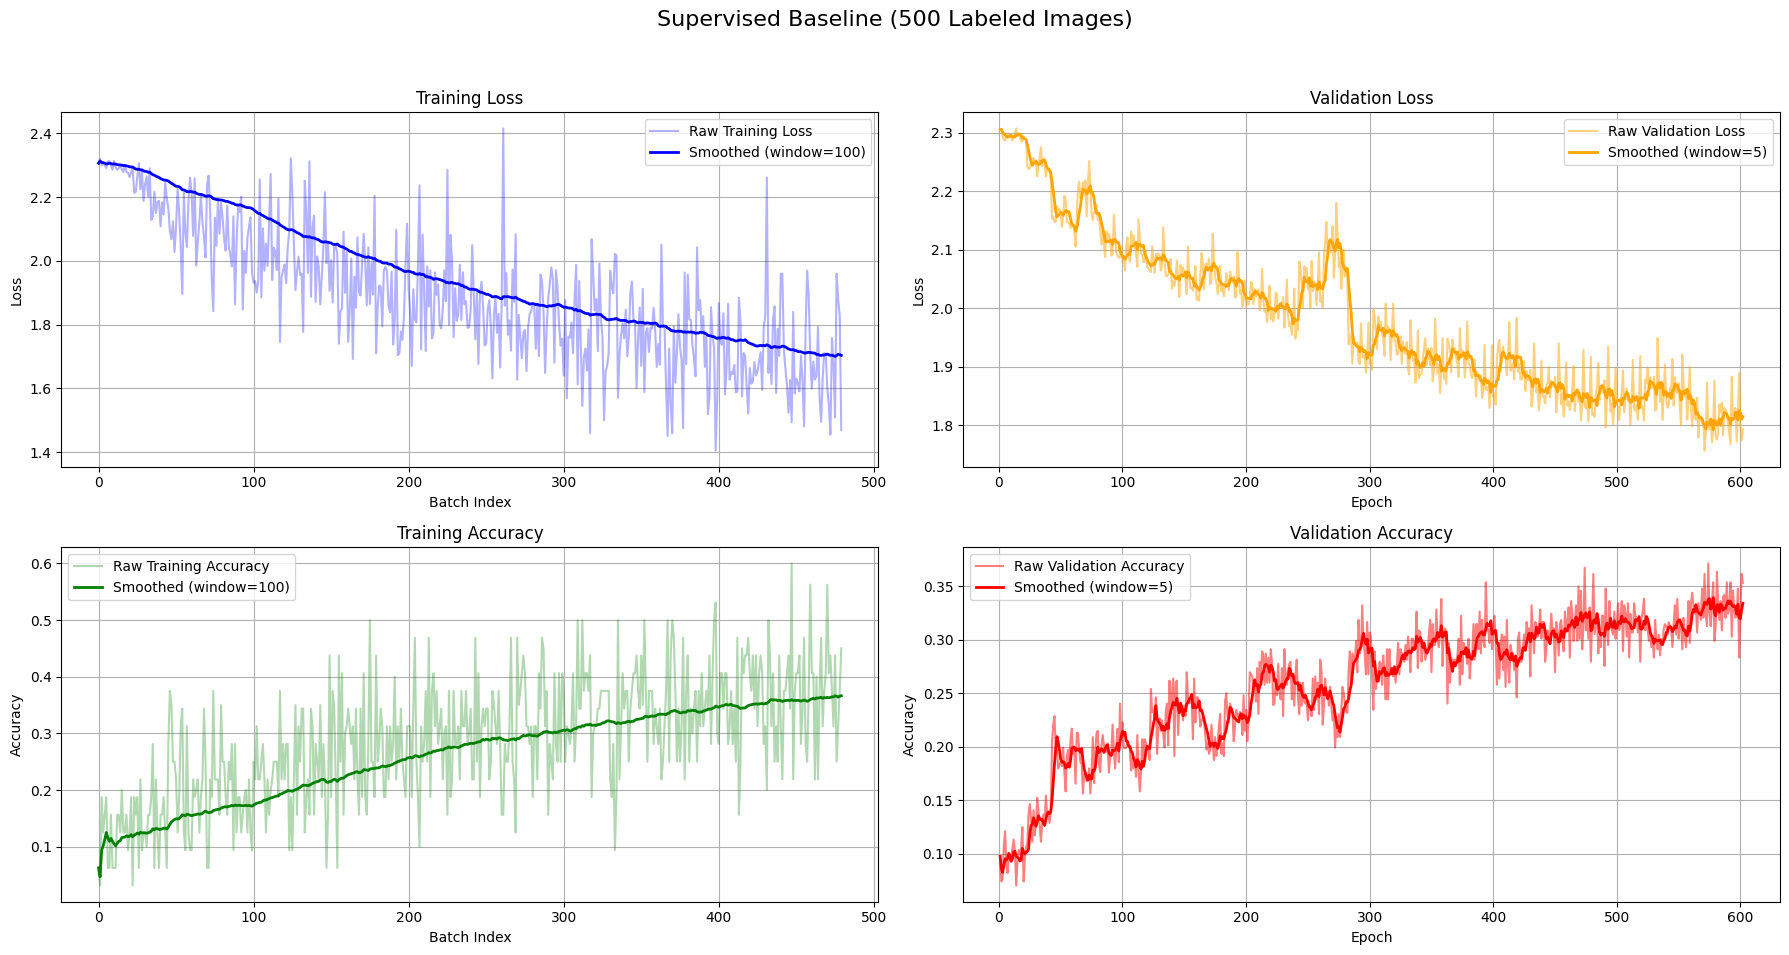

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x, return_features=False):
        f = self.features(x).flatten(1)
        if return_features:
            return f
        return self.classifier(f)

class SupervisedBaseline(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = SimpleCNN()
        self.criterion = nn.CrossEntropyLoss()

        # Metric tracking for plots
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=-1) == y).float().mean()

        self.log('baseline/train_loss', loss)
        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=-1) == y).float().mean()

        self.log('baseline/val_acc', acc, prog_bar=True)
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

wandb_logger = WandbLogger(project=WANDB_PROJECT, name="Supervised-Baseline-500")
baseline_model = SupervisedBaseline()
trainer = pl.Trainer(max_epochs=30, logger=wandb_logger, enable_checkpointing=False)
trainer.fit(baseline_model,
            train_dataloaders=datamodule.train_dataloader_supervised(),
            val_dataloaders=datamodule.val_dataloader())
wandb.finish()

# Let's plot the training curves for the Supervised Baseline
plot_training_curves(baseline_model, title="Supervised Baseline (500 Labeled Images)")

> 🛑 **Checkpoint 1**
>
> Look at the validation accuracy curve. Are you obtaining similar curves and values?

> 📝 **Reflection 2**
>
> <i>Briefly comment on the performance you obtained.</i>
>
> Your text here

## Part 2: SimCLR Pre-training
Now we implement SimCLR. The core idea:
1. Take an image `x`.
2. Apply random augmentations twice to get two different views: `x_i` and `x_j`.
3. Pass both through the CNN to get features, then through an MLP projection head to get embeddings `z_i` and `z_j`.
4. Maximize the similarity between `z_i` and `z_j` (positive pairs) while minimizing similarity with all other images in the batch (negative pairs).

> ☑️ **TODO 2**
>
> Implement the SimCLR Augmentation Pipeline. We will use PyTorch vision transforms since our data is already batched tensors on the GPU.

In [10]:
class SimCLRAugmentations(nn.Module):
    def __init__(self):
        super().__init__()
        # ☑️ TODO 2: Create a composition of RandomResizedCrop (size 32, scale (0.8, 1.0)), RandomHorizontalFlip (p=0.5), and ColorJitter (0.4 for brightness, contrast and saturation, 0.1 for hue).
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>

    def forward(self, x):
        return self.transform(x)

Let's now check if transformations are working as expected:

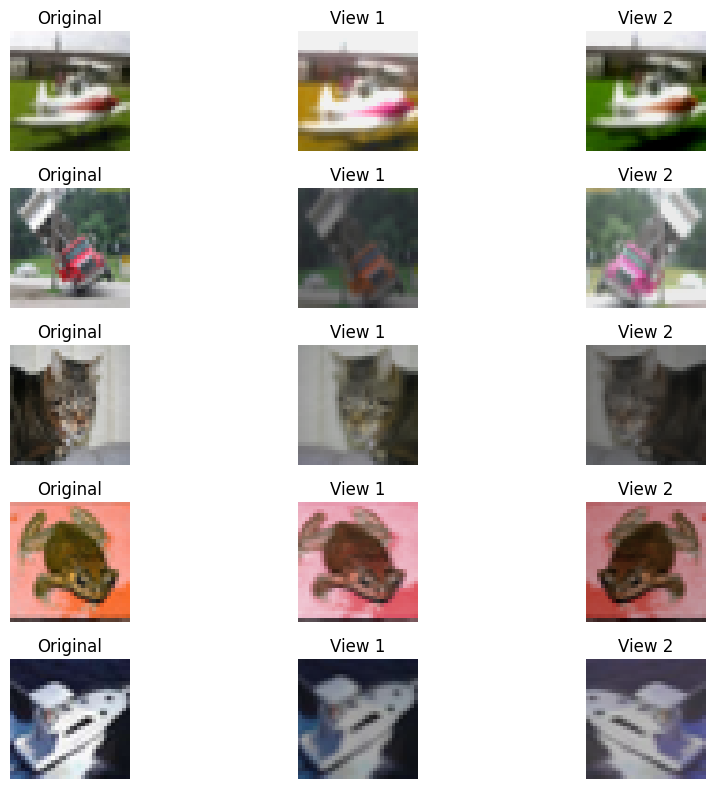

In [11]:
sample_batch = next(iter(datamodule.train_dataloader_unsupervised()))
sample_images = sample_batch[0][:5] # Take the first 5 images from the batch

augment_fn = SimCLRAugmentations()

plt.figure(figsize=(10, 8))
for i in range(len(sample_images)):
    original_image = sample_images[i]

    # Generate two augmented views
    view_1 = augment_fn(original_image.unsqueeze(0)).squeeze(0)
    view_2 = augment_fn(original_image.unsqueeze(0)).squeeze(0)

    # Plot original image
    plt.subplot(len(sample_images), 3, i * 3 + 1)
    plt.imshow(original_image.cpu().permute(1, 2, 0))
    plt.title("Original")
    plt.axis("off")

    # Plot view 1
    plt.subplot(len(sample_images), 3, i * 3 + 2)
    plt.imshow(view_1.cpu().permute(1, 2, 0))
    plt.title("View 1")
    plt.axis("off")

    # Plot view 2
    plt.subplot(len(sample_images), 3, i * 3 + 3)
    plt.imshow(view_2.cpu().permute(1, 2, 0))
    plt.title("View 2")
    plt.axis("off")

plt.tight_layout()
plt.show()

> 📝 **Reflection 3**
>
> <i>Comment on the transformations. What's their role in our context?</i>
>
> Your text here

> ☑️ **TODO 3**
>
> Implement the NT-Xent (InfoNCE) Loss. This is the heart of SimCLR.


In [12]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    z_i: embedding of view 1, shape (B, D)
    z_j: embedding of view 2, shape (B, D)
    """
    batch_size = z_i.size(0)

    # 1. Concatenate z_i and z_j => shape (2B, D)
    z = torch.cat([z_i, z_j], dim=0)

    # 2. Normalize embeddings to unit vectors
    z = F.normalize(z, dim=1)

    # 3. TODO: Compute cosine similarity matrix (2B x 2B) using matrix multiplication
    # <YOUR CODE HERE>
    
    # </YOUR CODE HERE>

    # 4. TODO: Divide by temperature
    # <YOUR CODE HERE>

    # </YOUR CODE HERE>

    # 5. Mask out self-similarity (the diagonal)
    sim_matrix.fill_diagonal_(-1e9)

    # 6. TODO: Create labels for CrossEntropy.
    # We will implement InfoNCE with a simple CrossEntropy loss
    # For that, we need to define labels for the 2B images
    # If batch size is 128, we need labels to be
    # 128, 129, ...., 255, 0, 1, ..., 127
    # <YOUR CODE HERE>

    # </YOUR CODE HERE>

    # 7. Compute CrossEntropy loss
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

> 📝 **Reflection 4**
>
> <i>Comment on why we defined labels as we did and how a simple CrossEntropy loss allows to implement InfoNCE.</i>
>
> Your text here

> 📝 **Reflection 5**
>
> <i>What is the role of the `temperature` parameter in the `nt_xent_loss`? What happens to the similarity logits if the temperature is very small (e.g., 0.01) versus very large (e.g., 10.0)?</i>
>
> Your text here

> ☑️ **TODO 4**
>
> Complete the SimCLR Forward Pass to generate views, extract embeddings, and compute the loss.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.



🚀 Starting SimCLR Pre-training (this will take 2-3 minutes)...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ SimpleCNN           │ 93.2 K │ train │     0 │
│ 1 │ projection_head │ Sequential          │ 24.8 K │ train │     0 │
│ 2 │ augment         │ SimCLRAugmentations │      0 │ train │     0 │
└───┴─────────────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 118 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 118 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 17                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
simclr/loss,█▆▅▄▆▂▃▃▃▃▃▂▃▂▂▂▂▃▃▃▁▃▁▂▂▁▁▂▁▂▂▁▂▃▁▁▂▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
epoch,29
simclr/loss,5.32419
trainer/global_step,2899


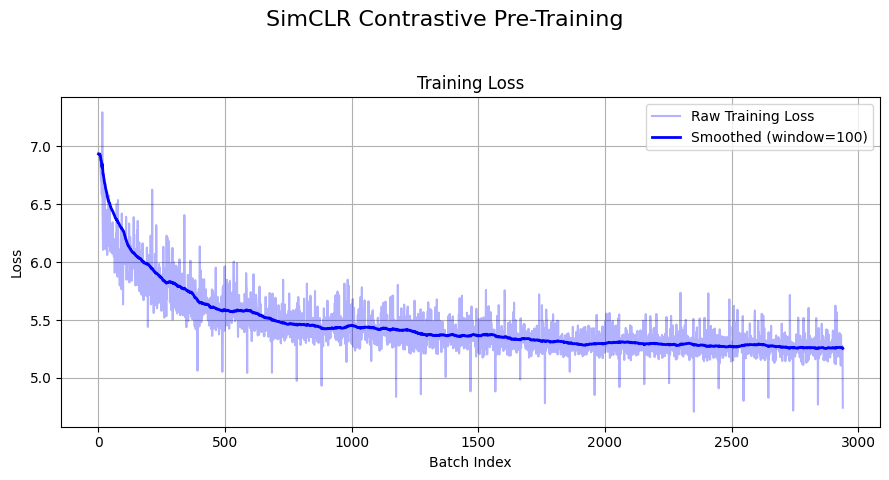

In [7]:
class SimCLR(pl.LightningModule):
    def __init__(self, hidden_dim=128, proj_dim=64):
        super().__init__()
        self.encoder = SimpleCNN()
        self.encoder.classifier = nn.Identity() # Replace classifier with Identity

        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, proj_dim)
        )
        self.augment = SimCLRAugmentations()

        # Metric tracking
        self.train_losses = []

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return h, z

    def training_step(self, batch, batch_idx):
        x = batch[0] # Unsupervised dataloader just yields images

        # TODO: Complete the forward pass
        # 1. Generate two views using self.augment
        # 2. Get embeddings using self(view)
        # 3. Compute loss using nt_xent_loss

        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>

        self.log('simclr/loss', loss)
        self.train_losses.append(loss.item())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)

wandb_logger = WandbLogger(project=WANDB_PROJECT, name="SimCLR-Pretraining")
simclr_model = SimCLR()
trainer = pl.Trainer(max_epochs=30, logger=wandb_logger, enable_checkpointing=False)

# Train on the FULL unlabeled dataset
print("\n🚀 Starting SimCLR Pre-training (this will take 2-3 minutes)...")
trainer.fit(simclr_model, train_dataloaders=datamodule.train_dataloader_unsupervised())
wandb.finish()

# Plot SimCLR training loss
plot_training_curves(simclr_model, title="SimCLR Contrastive Pre-Training")

> 🏁 **Milestone 1**
>
> You have successfully pre-trained the SimCLR encoder!

## Part 3: Linear Probing

Now we test if our self-supervised features are actually useful. We will freeze the pre-trained encoder and train *only* a new linear head.

> ☑️ **TODO 5**
>
> Define the linear layer for the `LinearProbe` module.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.



🚀 Starting Linear Probing...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder    │ SimpleCNN        │ 93.2 K │ eval  │     0 │
│ 1 │ classifier │ Linear           │  1.3 K │ train │     0 │
│ 2 │ criterion  │ CrossEntropyLoss │      0 │ train │     0 │
└───┴────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 K                                                                                            
Non-trainable params: 93.2 K                                                                                       
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 2                                                                                           
Modules in eval mode: 12                                                                                           
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:534: Found 12 module(s) in eval mode at
the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore
this warning.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
probe/train_loss,█▆▃▅▄▃▂▁▆
probe/val_acc,▁▂▄▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
epoch,29
probe/train_loss,1.80585
probe/val_acc,0.3601
trainer/global_step,479


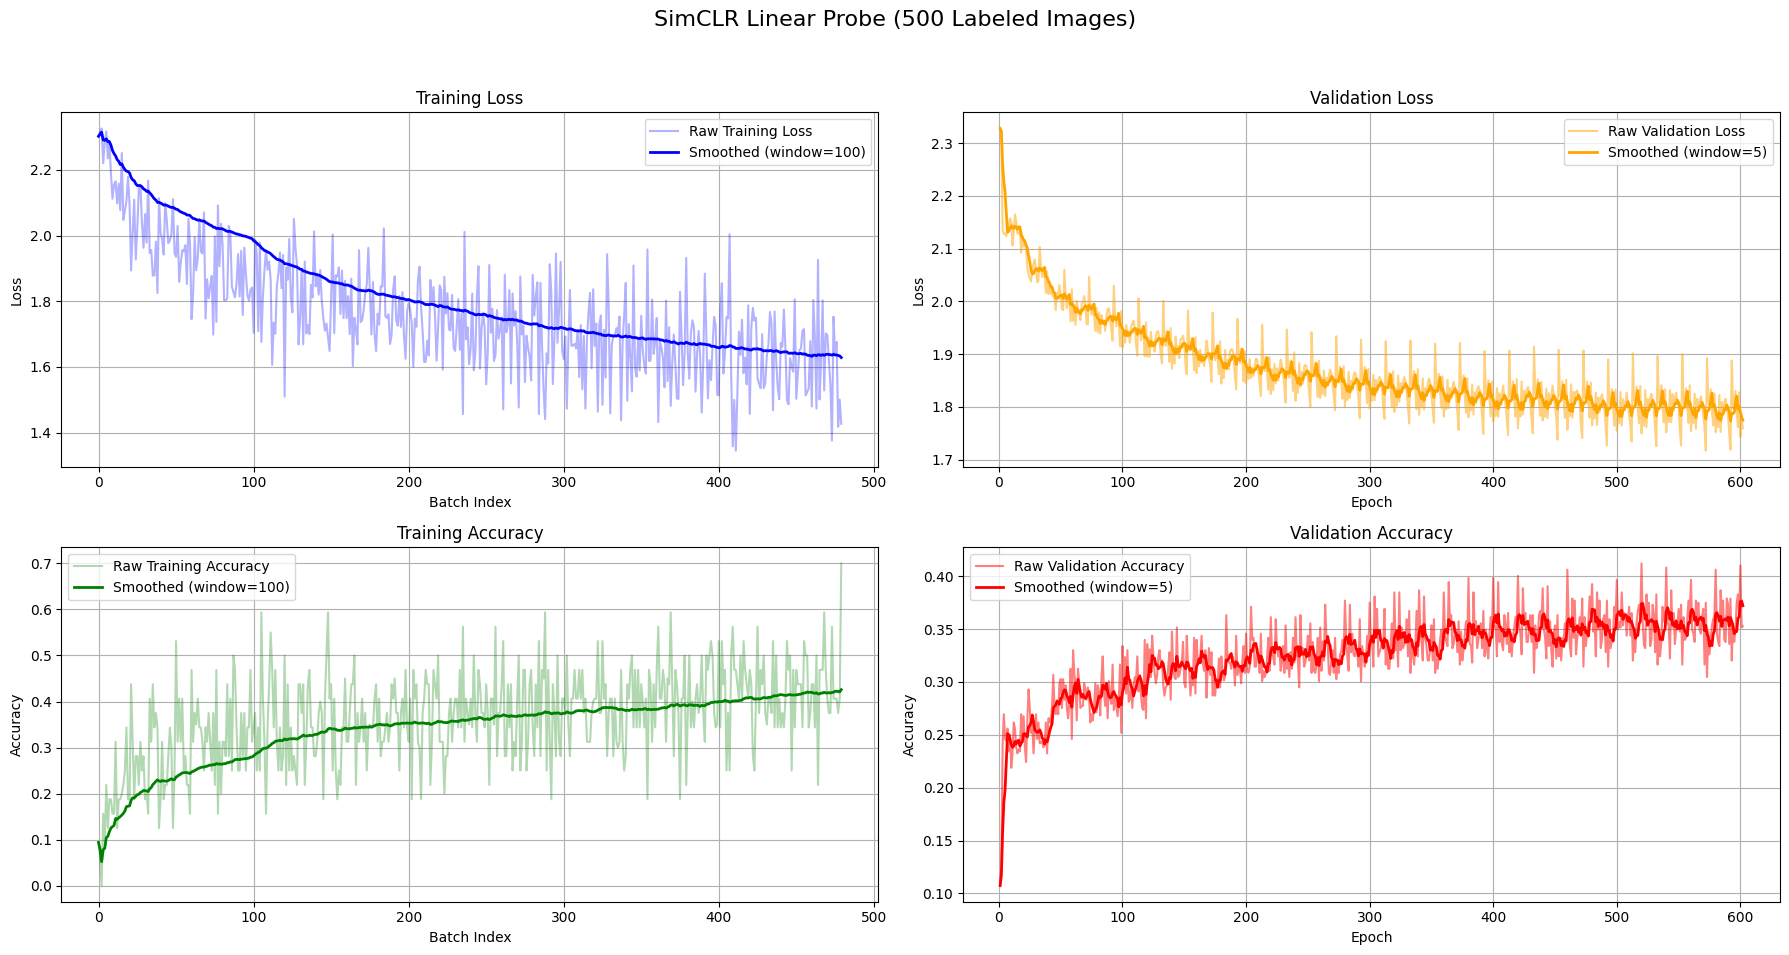

In [8]:
class LinearProbe(pl.LightningModule):
    def __init__(self, pretrained_encoder, num_classes=10):
        super().__init__()
        self.encoder = pretrained_encoder
        self.encoder.eval()
        for param in self.encoder.parameters():
            param.requires_grad = False # FREEZE ENCODER

        # TODO: Define a single Linear layer for classification
        # Remember, the hidden_dim of our SimpleCNN features is 128
        # <YOUR CODE HERE>

        # </YOUR CODE HERE>

        # Define self.criterion
        # <YOUR CODE HERE>

        # </YOUR CODE HERE>

        # Metric tracking
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        with torch.no_grad():
            features = self.encoder(x)
        logits = self.classifier(features)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=-1) == y).float().mean()

        self.log('probe/train_loss', loss)
        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        with torch.no_grad():
            features = self.encoder(x)
        logits = self.classifier(features)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=-1) == y).float().mean()

        self.log('probe/val_acc', acc, prog_bar=True)
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())

    def configure_optimizers(self):
        return torch.optim.Adam(self.classifier.parameters(), lr=1e-2)

print("\n🚀 Starting Linear Probing...")
wandb_logger = WandbLogger(project=WANDB_PROJECT, name="SimCLR-LinearProbe")
pretrained_encoder = simclr_model.encoder
probe_model = LinearProbe(pretrained_encoder)
trainer = pl.Trainer(max_epochs=30, logger=wandb_logger, enable_checkpointing=False)
trainer.fit(probe_model,
            train_dataloaders=datamodule.train_dataloader_supervised(),
            val_dataloaders=datamodule.val_dataloader())
wandb.finish()

plot_training_curves(probe_model, title="SimCLR Linear Probe (500 Labeled Images)")

> 🛑 **Checkpoint 2**
>
> Are you obtaining a similar output and accuracy?

> 📝 **Reflection 6**
>
> <i>Compare the performance of the Baseline and Linear Probe and briefly comment.</i>
>
> Your text here

> 🏁 **Milestone 2**
>
> You have successfully adapted a self-supervised model to a downstream task using multiple techniques!

## Part 4: Data Efficiency Ablation Study

Let's perform a formal ablation study to see how Supervised Baselines and SimCLR Linear Probes behave as we increase the amount of labeled training data.


🚀 Running Data Efficiency Ablation...

--- Testing with 50 labeled examples ---


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN        │ 94.5 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 94.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder    │ SimpleCNN        │ 93.2 K │ eval  │     0 │
│ 1 │ classifier │ Linear           │  1.3 K │ train │     0 │
│ 2 │ criterion  │ CrossEntropyLoss │      0 │ train │     0 │
└───┴────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 K                                                                                            
Non-trainable params: 93.2 K                                                                                       
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 2                                                                                           
Modules in eval mode: 12                                                                                           
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



--- Testing with 100 labeled examples ---


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN        │ 94.5 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 94.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder    │ SimpleCNN        │ 93.2 K │ eval  │     0 │
│ 1 │ classifier │ Linear           │  1.3 K │ train │     0 │
│ 2 │ criterion  │ CrossEntropyLoss │      0 │ train │     0 │
└───┴────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 K                                                                                            
Non-trainable params: 93.2 K                                                                                       
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 2                                                                                           
Modules in eval mode: 12                                                                                           
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



--- Testing with 500 labeled examples ---


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN        │ 94.5 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 94.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder    │ SimpleCNN        │ 93.2 K │ eval  │     0 │
│ 1 │ classifier │ Linear           │  1.3 K │ train │     0 │
│ 2 │ criterion  │ CrossEntropyLoss │      0 │ train │     0 │
└───┴────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 K                                                                                            
Non-trainable params: 93.2 K                                                                                       
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 2                                                                                           
Modules in eval mode: 12                                                                                           
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



--- Testing with 1000 labeled examples ---


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN        │ 94.5 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 94.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder    │ SimpleCNN        │ 93.2 K │ eval  │     0 │
│ 1 │ classifier │ Linear           │  1.3 K │ train │     0 │
│ 2 │ criterion  │ CrossEntropyLoss │      0 │ train │     0 │
└───┴────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 K                                                                                            
Non-trainable params: 93.2 K                                                                                       
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 2                                                                                           
Modules in eval mode: 12                                                                                           
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



--- Testing with 5000 labeled examples ---


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ SimpleCNN        │ 94.5 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 94.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder    │ SimpleCNN        │ 93.2 K │ eval  │     0 │
│ 1 │ classifier │ Linear           │  1.3 K │ train │     0 │
│ 2 │ criterion  │ CrossEntropyLoss │      0 │ train │     0 │
└───┴────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 1.3 K                                                                                            
Non-trainable params: 93.2 K                                                                                       
Total params: 94.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 2                                                                                           
Modules in eval mode: 12                                                                                           
Total FLOPs: 0

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


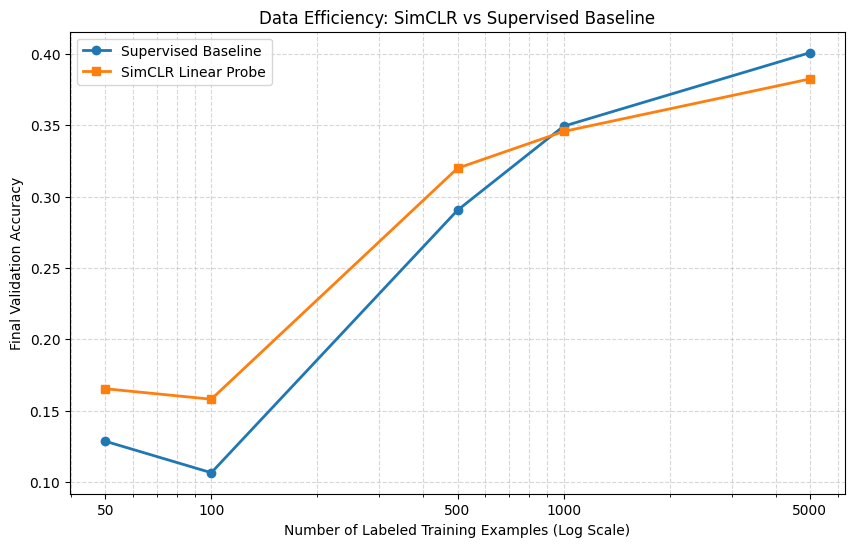

In [9]:
print("\n🚀 Running Data Efficiency Ablation...")
subset_sizes = [50, 100, 500, 1000, 5000]
baseline_accs = []
probe_accs = []

# To save time in the lab, we will train for fewer epochs during the ablation loop
ABLATION_EPOCHS = 15

for size in subset_sizes:
    print(f"\n--- Testing with {size} labeled examples ---")

    # Setup data
    dm_ablation = GPUCIFAR10DataModule(num_labeled=size)
    dm_ablation.prepare_data()
    dm_ablation.setup()

    # 1. Train Baseline
    baseline = SupervisedBaseline()
    trainer = pl.Trainer(max_epochs=ABLATION_EPOCHS, logger=False, enable_checkpointing=False, enable_progress_bar=False)
    trainer.fit(baseline, dm_ablation.train_dataloader_supervised(), dm_ablation.val_dataloader())
    # Retrieve the last validation accuracy from our tracked lists
    baseline_accs.append(baseline.val_accs[-1] if baseline.val_accs else 0.0)

    # 2. Train Probe (using our previously trained SimCLR encoder!)
    probe = LinearProbe(pretrained_encoder)
    trainer = pl.Trainer(max_epochs=ABLATION_EPOCHS, logger=False, enable_checkpointing=False, enable_progress_bar=False)
    trainer.fit(probe, dm_ablation.train_dataloader_supervised(), dm_ablation.val_dataloader())
    probe_accs.append(probe.val_accs[-1] if probe.val_accs else 0.0)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(subset_sizes, baseline_accs, marker='o', label='Supervised Baseline', linewidth=2)
plt.plot(subset_sizes, probe_accs, marker='s', label='SimCLR Linear Probe', linewidth=2)
plt.xscale('log')
plt.xticks(subset_sizes, labels=[str(s) for s in subset_sizes])
plt.xlabel("Number of Labeled Training Examples (Log Scale)")
plt.ylabel("Final Validation Accuracy")
plt.title("Data Efficiency: SimCLR vs Supervised Baseline")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

> 📝 **Reflection 7**
>
> <i>Analyze the ablation curve above. What happens to the gap between the Supervised Baseline and the SimCLR Probe as the number of labeled images increases from 50 to 5000? Why does this phenomenon occur?</i>
>
> Your text here

> 🏁 **Milestone 3**
>
> Lab Completed! You have rigorously proven the data-efficiency benefits of Self-Supervised Learning.

## Part 5: Extensions & Homework

Now that you have implemented Contrastive Learning, here are some challenging extensions to deepen your understanding.

### 📝 1. Implement a Non-Contrastive SSL Method (BYOL or SimSiam)
SimCLR requires negative samples, which necessitates large batch sizes.
* **Task:** Read the SimSiam paper (Chen & He, 2020) and modify your `SimCLR` class.
* **The Challenge:** Remove the negative pairs from the loss function and introduce a Stop-Gradient operation on one branch. How does performance compare to SimCLR at small batch sizes?

### 🧪 2. The Impact of Augmentations
Contrastive learning is heavily dependent on the chosen augmentations.
* **Task:** Perform an ablation on `SimCLRAugmentations`.
    * **Experiment:** Try removing `ColorJitter`. What happens to the learned representations?
    * **Hypothesis:** Without ColorJitter, the network might just compare color histograms between the two crops to solve the contrastive task, learning very little spatial semantics.

### 🔍 3. Semi-Supervised Fine-Tuning
* **Task:** Combine your knowledge. Unfreeze the encoder, but add the `nt_xent_loss` back into the fine-tuning step as a regularization term alongside the standard `CrossEntropyLoss` on the labeled data.
* **Question:** Does jointly optimizing the self-supervised and supervised objectives yield better results than sequential pre-train -> fine-tune?

---
**Submission:**
Please wrap up your code, ensure your WandB logs are synced and your link is in the notebook, and submit your notebook via email.